# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

1. Identify dimensions that influence car prices of used cars

2. Use PCA/Regression to identify dimensions that are influential in determining used car prices

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

1. Run summary stats on dataset
2. Understand dataset for missing values; Quantify the size of missing data to determine if they should be dropped/imputed
3. Determine categorical dimensions that could be used: Nominal /Ordinal

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error,r2_score
import warnings

In [24]:
data = pd.read_csv('data/vehicles.csv')

In [25]:
data.tail(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


In [26]:
data.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [27]:
#Source: https://github.com/toby-gardner-ai/uc-berkeley-aiml-course/blob/main/notebooks/Mod4_Data_Analytics.ipynb
def summary_stats(df) -> pd.DataFrame:

    # Create base frame
    stats = pd.DataFrame(index=df.columns)

    stats["dtype"] = df.dtypes


    stats["sample_val"] = [df[col].dropna().sample(1).iloc[0]
                            if df[col].notna().any() else np.nan
                            for col in df.columns]

    stats["vals"] = df.count()
    stats["miss_pct"] = (df.isna().sum() / len(df) * 100).round(1)
    stats["unique"] = df.nunique()

    # Initiate Descriptive Stats
    for col in ["mean", "mode", "min", "max", "std", "skew", "kurtosis"]:
        stats[col] = np.nan

    # Compute stats for numeric columns
    num_cols = df.select_dtypes(include="number").columns

    for col in num_cols:
        s = df[col].dropna()
        if not s.empty:
            stats.at[col, "mean"] = s.mean()
            stats.at[col, "min"] = s.min()
            stats.at[col, "max"] = s.max()
            stats.at[col, "std"] = s.std()
            #stats.at[col, "skew"] = s.skew().round(1)
            #stats.at[col, "kurtosis"] = s.kurtosis().round(1)
            mode_vals = s.mode()
            stats.at[col, "mode"] = mode_vals.iloc[0] if not mode_vals.empty else np.nan

    # Rounding preferences for numeric stats (change this to suit dataset)
    round_cols = ["mean", "mode", "min", "max", "std"]
    stats[round_cols] = stats[round_cols].round(2)

    return stats

In [28]:
summary_stats(data)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
id,int64,7309504542,426880,0.0,426880,7.311487e+09,7.207408e+09,7.207408e+09,7.317101e+09,4473170.41,NaN,NaN
region,object,new york city,426880,0.0,404,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,int64,0,426880,0.0,15655,7.519903e+04,0.000000e+00,0.000000e+00,3.736929e+09,12182282.17,NaN,NaN
year,float64,2016.0,425675,0.3,114,2.011240e+03,2.017000e+03,1.900000e+03,2.022000e+03,9.45,NaN,NaN
manufacturer,object,jeep,409234,4.1,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,object,mdx sh-awd sport utility,421603,1.2,29649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,object,good,252776,40.8,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,object,8 cylinders,249202,41.6,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,object,gas,423867,0.7,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,float64,42455.0,422480,1.0,104870,9.804333e+04,1.000000e+05,0.000000e+00,1.000000e+07,213881.50,NaN,NaN


In [29]:
data['cylinders'].value_counts()

cylinders
6 cylinders     94169
4 cylinders     77642
8 cylinders     72062
5 cylinders      1712
10 cylinders     1455
other            1298
3 cylinders       655
12 cylinders      209
Name: count, dtype: int64

In [30]:
data['title_status'].value_counts()

title_status
clean         405117
rebuilt         7219
salvage         3868
lien            1422
missing          814
parts only       198
Name: count, dtype: int64

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

1. Drop the following columns
   a. Identifiers
   b. VIN
   c. region(Use state instead)
   d. model(2196 unique values)
   e. condition
   f. cylinders
   g. size
   h. paint
   
3. Missing data imputation
    a. Replace missing data for title_status with 'missing'
    b. Replace missing data for fuel with 'other'
    c. Replace missing data for transmission with 'other'
    d. Replace missing data for year with average of year
    e. Replace missing data for manufacturer with 'other'
    f. Replace missing data for type with 'other'


4. Remove outliers from price & Odometer
5. Standardization of numeric variables for Lasso/Ridge
6. OneHot Encoding for other categorical variables
7. Ordinal Encoding for Title

In [31]:
#Removing outliers in Price and Odometer Readings
q1_price=data['price'].quantile(0.25)
q3_price=data['price'].quantile(0.75)
iqr_price=q3_price-q1_price
lower_price=max(1999,q1_price-1.5*iqr_price)
upper_price=q3_price+1.5*iqr_price

q1_odometer=data['odometer'].quantile(0.25)
q3_odometer=data['odometer'].quantile(0.75)
iqr_odometer=q3_odometer-q1_odometer
lower_odometer=max(2,q1_odometer-1.5*iqr_odometer)
upper_odometer=q3_odometer+1.5*iqr_odometer

print('25th percentile, 75th percentile, IQR, Upper, lower band for price',q1_price, q3_price, iqr_price, lower_price,upper_price)
print('25th percentile, 75th percentile, IQR, Upper, lower band for odometer',q1_odometer, q3_odometer, iqr_odometer, lower_odometer,upper_odometer)


data_clean=data[
    (data['price'] >=lower_price) &
    (data['price']<=upper_price) &
    (data['odometer']>lower_odometer) &
    (data['odometer']<=upper_odometer)
    ]
data_clean=data_clean.drop(columns=['VIN','region','model','size','paint_color','drive'])
year_avg=data['year'].mean()
data_clean['cylinder_count'] = data_clean['cylinders'].str.extract(r'(\d+)')
data_clean['cylinder_count']=data_clean['cylinder_count'].astype('Int64')
cylinder_avg=np.int64(round(data_clean['cylinder_count'].mean()))
print(cylinder_avg)
data_clean['cylinder_count'].fillna(cylinder_avg,inplace=True)
data_clean['title_status'].fillna('missing',inplace=True)
data_clean['condition'].fillna('missing',inplace=True)
data_clean['fuel'].fillna('other',inplace=True)
data_clean['transmission'].fillna('other',inplace=True)
data_clean['manufacturer'].fillna('other',inplace=True)
data_clean['type'].fillna('other',inplace=True)
data_clean['year'].fillna(year_avg,inplace=True)
data_clean['age_of_car']=2026-data_clean['year']
e=1
data_clean['log_price']=np.log(data_clean['price']+e)
data_clean.set_index('id')

25th percentile, 75th percentile, IQR, Upper, lower band for price 5900.0 26485.75 20585.75 1999 57364.375
25th percentile, 75th percentile, IQR, Upper, lower band for odometer 37704.0 133542.5 95838.5 2 277300.25
6


,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state,cylinder_count,age_of_car,log_price
id,,,,,,,,,,,,,,
7316814884,33590,2014.0,gmc,good,8 cylinders,gas,57923.0,clean,other,pickup,al,8,12.0,10.422013
7316814758,22590,2010.0,chevrolet,good,8 cylinders,gas,71229.0,clean,other,pickup,al,8,16.0,10.025307
7316814989,39590,2020.0,chevrolet,good,8 cylinders,gas,19160.0,clean,other,pickup,al,8,6.0,10.586357
7316743432,30990,2017.0,toyota,good,8 cylinders,gas,41124.0,clean,other,pickup,al,8,9.0,10.341452
7316356412,15000,2013.0,ford,excellent,6 cylinders,gas,128000.0,clean,automatic,truck,al,6,13.0,9.615872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7301591192,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,sedan,wy,6,7.0,10.068621
7301591187,30590,2020.0,volvo,good,NaN,gas,12029.0,clean,other,sedan,wy,6,6.0,10.328461
7301591147,34990,2020.0,cadillac,good,NaN,diesel,4174.0,clean,other,hatchback,wy,6,6.0,10.462846


In [32]:
summary_stats(data_clean)

,dtype,sample_val,vals,miss_pct,unique,mean,mode,min,max,std,skew,kurtosis
id,int64,7307370689,358022,0.0,358022,7.311441e+09,7.301583e+09,7.301583e+09,7.317101e+09,4394051.88,NaN,NaN
price,int64,32498,358022,0.0,13362,1.875186e+04,6.995000e+03,1.999000e+03,5.734100e+04,12447.21,NaN,NaN
year,float64,2019.0,358022,0.0,110,2.011200e+03,2.018000e+03,1.900000e+03,2.022000e+03,9.16,NaN,NaN
manufacturer,object,ram,358022,0.0,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,object,missing,358022,0.0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,object,8 cylinders,212932,40.5,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fuel,object,gas,358022,0.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odometer,float64,144230.0,358022,0.0,92895,9.205777e+04,2.000000e+05,3.000000e+00,2.772310e+05,60001.63,NaN,NaN
title_status,object,clean,358022,0.0,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
transmission,object,automatic,358022,0.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
data_clean['condition'].value_counts()

condition
missing      132687
good         114229
excellent     87562
like new      18326
fair           4155
new             791
salvage         272
Name: count, dtype: int64

In [34]:
data_clean['title_status'].value_counts()

title_status
clean         340139
rebuilt         6875
missing         6290
salvage         3356
lien            1303
parts only        59
Name: count, dtype: int64

In [35]:
fig=px.scatter(data_clean.groupby('cylinder_count')['price'].mean(),y='price')
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    title="Avg car price",
    xaxis_title='Number of cylinders',
    yaxis_title='Price'
)
fig.show()
fig.write_html('images/m11_price_cylinder.html')

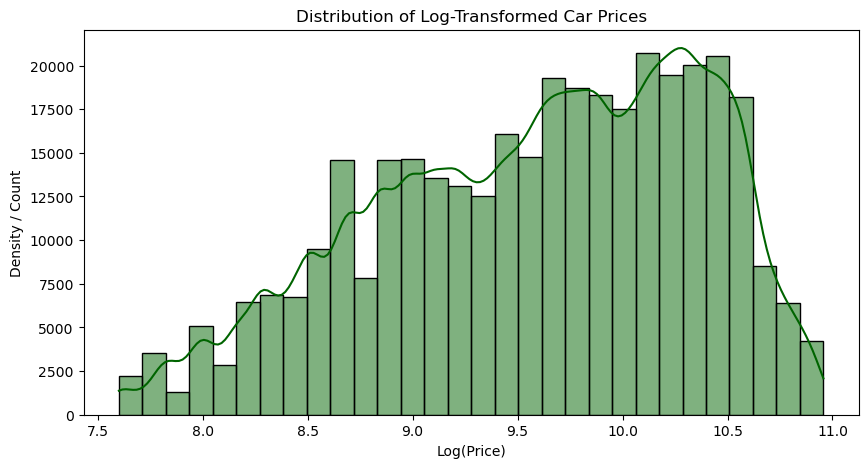

<Figure size 640x480 with 0 Axes>

In [36]:
import seaborn as sns
plt.figure(figsize=(10, 5))
# Plot a histogram with a Kernel Density Estimate (KDE) line
sns.histplot(data_clean['log_price'], kde=True, bins=30, color='darkgreen')
plt.title('Distribution of Log-Transformed Car Prices')
plt.xlabel('Log(Price)')
plt.ylabel('Density / Count')
plt.show()
plt.savefig('images/log_distribution.jpg')

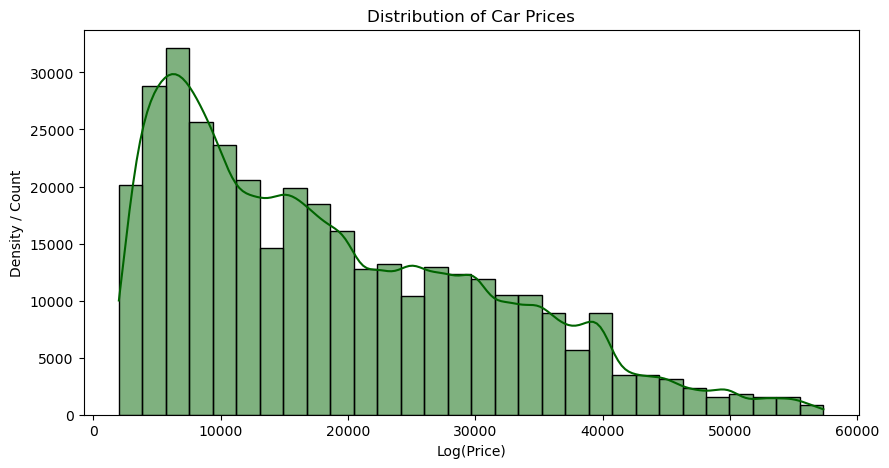

<Figure size 640x480 with 0 Axes>

In [37]:
import seaborn as sns
plt.figure(figsize=(10, 5))
# Plot a histogram with a Kernel Density Estimate (KDE) line
sns.histplot(data_clean['price'], kde=True, bins=30, color='darkgreen')
plt.title('Distribution of Car Prices')
plt.xlabel('Log(Price)')
plt.ylabel('Density / Count')
plt.show()
plt.savefig('images/car_price_distribution.jpg')

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Split data into Train and Test

In [38]:
X_train,X_test, y_train, y_test=train_test_split(data_clean.drop(['price','id','log_price','year'],axis=1),data_clean['log_price'],test_size=0.2)

Basic Linear Regression Model

In [45]:
X_train,X_test, y_train, y_test=train_test_split(data_clean[['odometer','age_of_car']],data_clean['price'],test_size=0.2)

In [46]:
lr=LinearRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
mae=np.abs(y_pred-y_test).mean()
print('Linear regression MSE:', mse)
print('Linear regression MAE:', mae)

Linear regression MSE: 98293025.81605533
Linear regression MAE: 7751.1281784344


In [64]:
X_train.head(10)

,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state,cylinder_count,age_of_car,log_price
418839,ram,missing,NaN,diesel,118823.0,clean,automatic,pickup,wi,6,17.0,10.308819
367531,chevrolet,missing,8 cylinders,gas,103861.0,clean,automatic,pickup,tx,8,12.0,10.123747
266160,ram,good,8 cylinders,gas,103300.0,clean,automatic,pickup,ny,8,20.0,8.293049
262372,volkswagen,excellent,4 cylinders,gas,58000.0,clean,automatic,sedan,nm,4,11.0,9.457279
346364,kia,good,4 cylinders,gas,45000.0,rebuilt,automatic,sedan,sc,4,11.0,8.987322
19202,bmw,good,6 cylinders,gas,148678.0,clean,automatic,sedan,ar,6,27.0,7.937732
236777,ford,missing,NaN,gas,133697.0,clean,automatic,other,nc,6,13.0,9.047351
38848,honda,excellent,6 cylinders,gas,53962.0,clean,automatic,SUV,ca,6,10.0,10.404142
220105,nissan,excellent,6 cylinders,gas,114726.0,clean,automatic,SUV,mo,6,12.0,9.445492
66661,nissan,missing,NaN,gas,125.0,clean,automatic,other,ca,6,18.0,8.294300


Linear Regression Model

In [19]:
numeric_cols = ['age_of_car', 'odometer','cylinder_count']
numeric_pipe = Pipeline([
    ('quad_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler(with_mean=False)) 
])


transformers = [
    ('onehot', 
     OneHotEncoder(drop='first', handle_unknown='ignore'), 
     ['manufacturer', 'fuel', 'transmission', 'type', 'state']),
    
    ('ordinal', 
     OrdinalEncoder(categories=[['parts only','missing','salvage','lien','rebuilt','clean']]),
     ['title_status']),
    ('ordinal_con',
     OrdinalEncoder(categories=[['salvage','missing','fair','good','excellent','like new','new']]),
     ['condition']),
     
    # Transformer C: Numeric Features
    ('numeric_transform',
     numeric_pipe,
     numeric_cols)
]

poly_ordinal_ohe = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)

# 2. Instantiate the main ColumnTransformer
pipe_linear = Pipeline([
    ('transformer', poly_ordinal_ohe), 
    ('ridge', LinearRegression())
])


In [78]:
pipe_linear.fit(X_train,y_train)

fitted_transformer = pipe_linear['transformer']
feature_names = fitted_transformer.get_feature_names_out()
#print(feature_names)

In [79]:
feature_names=pipe_linear['transformer'].get_feature_names_out()
coefficients=pipe_linear['ridge'].coef_
coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

# Sort by the absolute value of the coefficient to see the most important features
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')
coef_df.head(50)
#coef_df.tail(60)

,Feature,Coefficient
29,onehot__manufacturer_morgan,1.455833
42,onehot__fuel_electric,-0.878169
112,numeric_transform__age_of_car,-0.857988
8,onehot__manufacturer_datsun,0.832488
44,onehot__fuel_hybrid,-0.726573
38,onehot__manufacturer_tesla,0.707847
43,onehot__fuel_gas,-0.681603
1,onehot__manufacturer_aston-martin,0.661422
115,numeric_transform__age_of_car^2,0.569003
45,onehot__fuel_other,-0.568686


In [80]:
y_pred=pipe_linear.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
mae=np.abs(y_pred-y_test).mean()
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print('Linear regression MSE:', mse)
print('Linear regression MAE:', mae)

 R-squared: 0.7235043045319764
Linear regression MSE: 0.16462899757591853
Linear regression MAE: 0.2951957888348407


RIDGE Regression Model

Hyper parameter tuning for Ridge Model

In [81]:
# Pipe for Ridge
pipe_ridge = Pipeline([
    ('transformer', poly_ordinal_ohe), 
    ('ridge', Ridge())
])

In [ ]:
param_grid = {'ridge__alpha': [0.1, 1.0, 10.0, 100.0,1000.0]}

# 2. Set up the grid search
grid_search = GridSearchCV(
    estimator=pipe_ridge,       # Pass your pipeline here
    param_grid=param_grid,      # Pass the dictionary of parameters
    scoring='neg_mean_squared_error', # Choose your metric
    cv=5,                       # Use 5-fold cross-validation
    verbose=1
)

# 3. Run the search
grid_search.fit(X_train, y_train)

In [ ]:
# 4. Get the best alpha
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"The optimal alpha value found is: {best_alpha}")

# 5. Get the best trained model (which is the pipeline with the best alpha)
best_pipeline = grid_search.best_estimator_

In [39]:
pipe_ridge_b = Pipeline([
    ('transformer', poly_ordinal_ohe), 
    ('ridge', Ridge(alpha=0.1))
])

In [40]:
pipe_ridge_b.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['manufacturer', 'fuel',
                                                   'transmission', 'type',
                                                   'state']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['parts '
                                                                              'only',
                                                                              'missing',
                                                                              'salvage',
                                                                              'lien',
                                                                              'rebuilt',
                                                                              'clean']]),
                                                  ['title_status']),
                                                 ('ordinal_con',
                                                  OrdinalEncoder(categories=[['salvage',
                                                                              'missing',
                                                                              'fair',
                                                                              'good',
                                                                              'excellent',
                                                                              'like '
                                                                              'new',
                                                                              'new']]),
                                                  ['condition']),
                                                 ('numeric_transform',
                                                  Pipeline(steps=[('quad_features',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['age_of_car', 'odometer',
                                                   'cylinder_count'])])),
                ('ridge', Ridge(alpha=0.1))])

In [42]:
feature_names_ridge=pipe_ridge_b['transformer'].get_feature_names_out()
coefficients_ridge=pipe_ridge_b['ridge'].coef_
coef_df_ridge = pd.DataFrame({
        'Feature': feature_names_ridge,
        'Coefficient': coefficients_ridge
    })

# Sort by the absolute value of the coefficient to see the most important features
coef_df_ridge['Abs_Coefficient'] = np.abs(coef_df_ridge['Coefficient'])
coef_df_ridge = coef_df_ridge.sort_values(by='Abs_Coefficient', ascending=False).drop(columns='Abs_Coefficient')
coef_df_ridge.head(50)

,Feature,Coefficient
8,onehot__manufacturer_datsun,0.897655
41,onehot__fuel_electric,-0.862102
111,numeric_transform__age_of_car,-0.856353
43,onehot__fuel_hybrid,-0.720715
37,onehot__manufacturer_tesla,0.685921
42,onehot__fuel_gas,-0.680117
44,onehot__fuel_other,-0.567523
114,numeric_transform__age_of_car^2,0.564223
35,onehot__manufacturer_saturn,-0.526029
32,onehot__manufacturer_porsche,0.504128


In [85]:
y_pred=pipe_ridge_b.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
mae=np.abs(y_pred-y_test).mean()
r2_square = r2_score(y_test,y_pred)
print(f" R-squared: {r2_square}")
print('Ridge regression MSE:', mse)
print('Ridge regression MAE:', mae)
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

 R-squared: 0.7235153677685134
Ridge regression MSE: 0.164622410386422
Ridge regression MAE: 0.29517842737474875


,Actual Value,Predicted Value,Difference
349640,9.071193,9.132375,-0.061181
52652,9.900984,9.810809,0.090175
233692,8.513587,8.806674,-0.293087
380932,9.510519,9.592153,-0.081634
377147,10.515587,10.043704,0.471883
...,...,...,...
386033,10.403990,10.034462,0.369528
65246,9.878118,10.361328,-0.483209
92464,10.403990,10.119903,0.284087
371178,10.341452,9.850085,0.491368


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

MODEL EVALUATION and FINE TUNING

In initial model development and evaluation, used Linear Regression and Ridge to evaluate performance of Model. 
For Ridge model, i used hyper parameter tuning to determine the best alpha for the model.Best alpha was 0.1, meaning it replicated performance similar to Linear Regression

In fine tuning phase,
1. Removed cars with pricing under 2000$ to get a normal distribution of Log price of cars (Shown in image car_price_distribution.jpg)
2. brought in Power of the vehicle(Cylinders) after imputating the missing data. % of data missing was little high but number of cylinders had a linear relationship with mean price of Cars

MAE is now significantly lower ~$4.3K and Proportion of variance for Car price explained by independent variables is 72.5% (R-squared)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Primary Findings
1. Car price decreases significantly every year, but the rate of that decrease diminishes as the car ages.
2. Mileage(Odometer) negatively influences car prices
2. Luxury Cars such as Morgan, Datsun, Aston Martin, Porshe, Rover go at a premium. Almost all other brands have no positive weightage on pricing
3. Fuel Type: Electric and Hybrid cars are less favorable than traditional gas engines
4. Offroad and Truck are sold are premium
5. Region wise, there is marginal variations with east coast states like Connecticut and NJ penalized more; Likely due to rough winter weathers